In [1]:
!pip install kaggle


In [4]:
from google.colab import files
uploaded = files.upload()  # Upload movies_metadata.csv and ratings.csv


Saving movies_metadata.csv to movies_metadata.csv
Saving ratings.csv to ratings.csv


In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import requests


# Load movies metadata and ratings datasets
movies_df = pd.read_csv('movies_metadata.csv', low_memory=False)
ratings_df = pd.read_csv('ratings.csv')

# View the first few rows of the datasets
print(movies_df.head())
print(ratings_df.head())


   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

In [23]:
print(movies_df.columns)

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


In [24]:
print(ratings_df.columns)

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [25]:
# Convert the 'vote_average' and 'vote_count' columns to numeric, coerce errors
movies_df['vote_average'] = pd.to_numeric(movies_df['vote_average'], errors='coerce')
movies_df['vote_count'] = pd.to_numeric(movies_df['vote_count'], errors='coerce')

# Drop rows with missing or invalid data
movies_df = movies_df.dropna(subset=['vote_average', 'vote_count', 'title'])

# Keep necessary columns
movies_df = movies_df[['title', 'genres', 'vote_average', 'vote_count', 'release_date']]

# Preview the cleaned dataset
movies_df.head()


,title,genres,vote_average,vote_count,release_date
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",7.7,5415.0,1995-10-30
1,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",6.9,2413.0,1995-12-15
2,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",6.5,92.0,1995-12-22
3,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",6.1,34.0,1995-12-22
4,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",5.7,173.0,1995-02-10


In [27]:
movies_df['id'] = range(1, len(movies_df) + 1)

# Display the updated dataframe
movies_df.head()

,title,genres,vote_average,vote_count,release_date,id
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",7.7,5415.0,1995-10-30,1
1,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",6.9,2413.0,1995-12-15,2
2,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",6.5,92.0,1995-12-22,3
3,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",6.1,34.0,1995-12-22,4
4,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",5.7,173.0,1995-02-10,5


In [28]:
# Merge ratings and movies data
ratings_df = pd.merge(ratings_df, movies_df, left_on='movieId', right_on='id', how='inner')

# Display merged data
ratings_df.head()


,userId,movieId,rating,timestamp,title,genres,vote_average,vote_count,release_date,id
0,1,31,2.5,1260759144,Dangerous Minds,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",6.4,249.0,1995-08-11,31
1,7,31,3.0,851868750,Dangerous Minds,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",6.4,249.0,1995-08-11,31
2,31,31,4.0,1273541953,Dangerous Minds,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",6.4,249.0,1995-08-11,31
3,32,31,4.0,834828440,Dangerous Minds,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",6.4,249.0,1995-08-11,31
4,36,31,3.0,847057202,Dangerous Minds,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",6.4,249.0,1995-08-11,31


In [29]:
# Get top 10 most rated movies
top_rated_movies = movies_df.sort_values(by='vote_count', ascending=False).head(10)

# Display the top-rated movies
print(top_rated_movies[['title', 'vote_count', 'vote_average']])


                         title  vote_count  vote_average
15480                Inception     14075.0           8.1
12481          The Dark Knight     12269.0           8.3
14551                   Avatar     12114.0           7.2
17818             The Avengers     12000.0           7.4
26564                 Deadpool     11444.0           7.4
22879             Interstellar     11187.0           8.1
20051         Django Unchained     10297.0           7.8
23753  Guardians of the Galaxy     10014.0           7.9
2843                Fight Club      9678.0           8.3
18244         The Hunger Games      9634.0           6.9


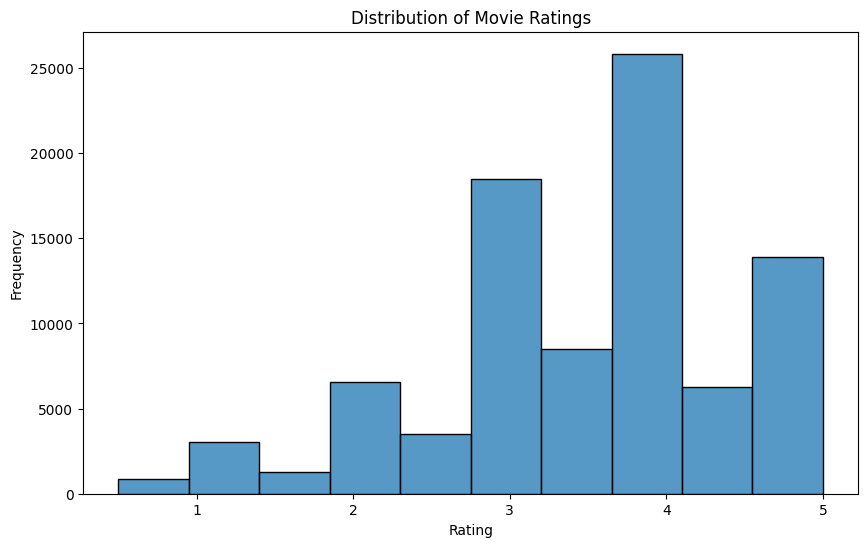

In [33]:
plt.figure(figsize=(10,6))
sns.histplot(ratings_df['rating'], bins=10, kde=False)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


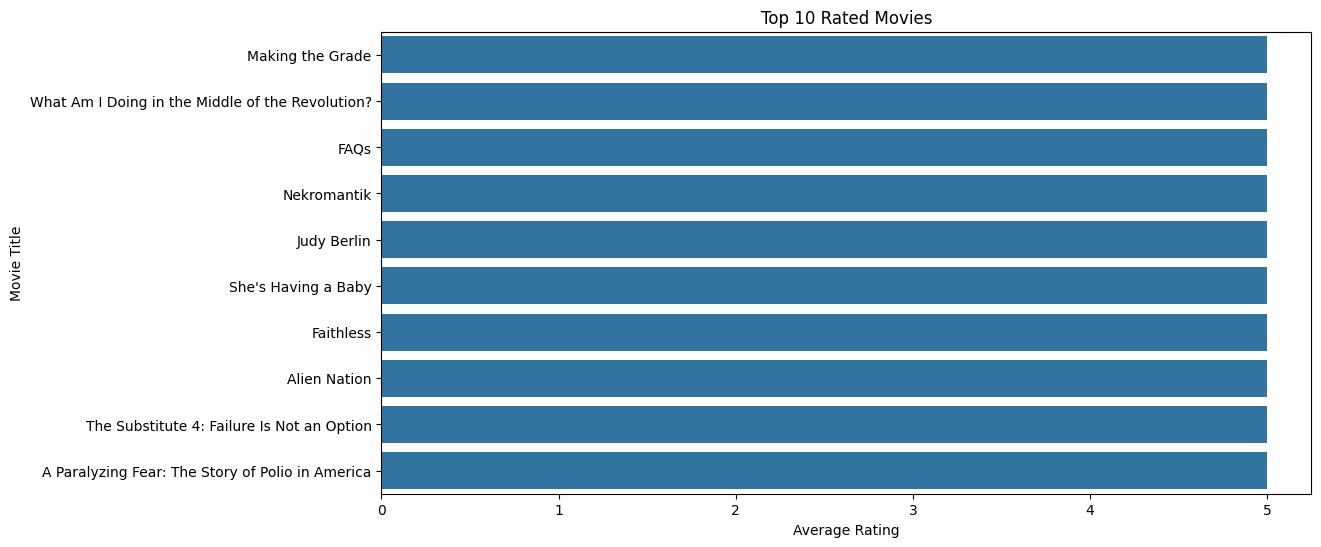

In [34]:
top_rated = ratings_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_rated.values, y=top_rated.index)
plt.title('Top 10 Rated Movies')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()


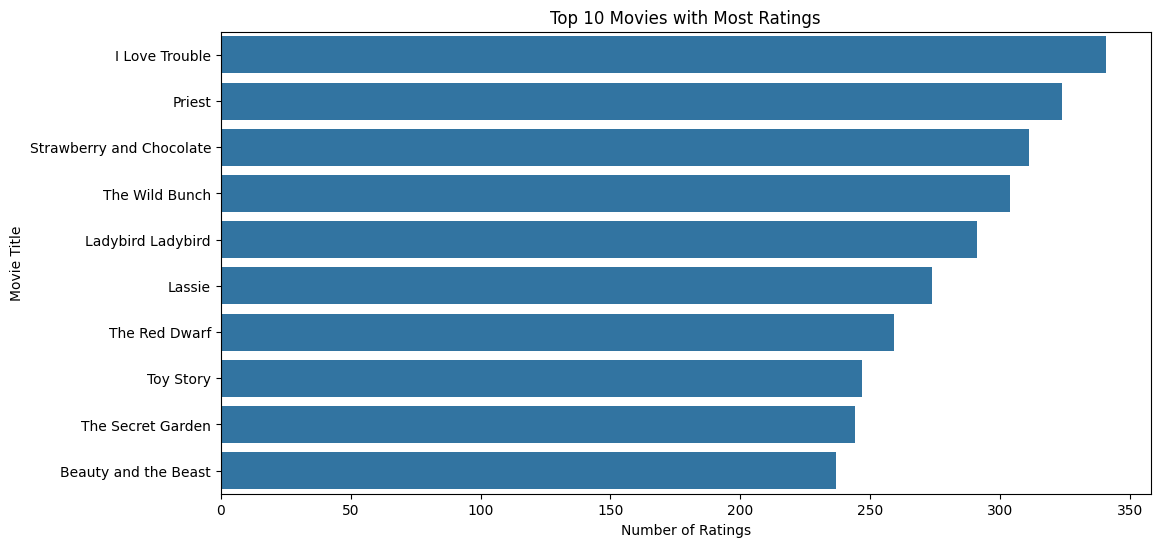

In [35]:
ratings_count = ratings_df.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=ratings_count.values, y=ratings_count.index)
plt.title('Top 10 Movies with Most Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()
